# 1.數據準備

In [1]:
from pandas import read_csv
from datetime import datetime

In [2]:
datafile = 'D:/ML/HFenergy/风场1/x26/2018-07-30.csv'
dataset = read_csv(datafile,index_col=0)
dataset=dataset.dropna()

In [3]:
dataset.head()

,变频器电网侧有功功率,外界温度,风向,风速
time,,,,
2018-07-30 00:00:00,0.0,0.74,0.936787,0.040727
2018-07-30 00:00:30,0.0,0.74,0.932609,0.045691
2018-07-30 00:01:00,0.0,0.74,0.917778,0.056391
2018-07-30 00:01:30,0.0,0.74,0.929074,0.056307
2018-07-30 00:02:00,0.0,0.74,0.947130,0.056892


In [4]:
#建議使用英文頭
dataset.columns = ['power', 'temp', 'wnd_dir', 'wnd_spd']
dataset.head()

,power,temp,wnd_dir,wnd_spd
time,,,,
2018-07-30 00:00:00,0.0,0.74,0.936787,0.040727
2018-07-30 00:00:30,0.0,0.74,0.932609,0.045691
2018-07-30 00:01:00,0.0,0.74,0.917778,0.056391
2018-07-30 00:01:30,0.0,0.74,0.929074,0.056307
2018-07-30 00:02:00,0.0,0.74,0.947130,0.056892


In [5]:
dataset.index.name = 'date'
dataset.head()

,power,temp,wnd_dir,wnd_spd
date,,,,
2018-07-30 00:00:00,0.0,0.74,0.936787,0.040727
2018-07-30 00:00:30,0.0,0.74,0.932609,0.045691
2018-07-30 00:01:00,0.0,0.74,0.917778,0.056391
2018-07-30 00:01:30,0.0,0.74,0.929074,0.056307
2018-07-30 00:02:00,0.0,0.74,0.947130,0.056892


# 2.展示數據
變化，以便觀察並剔除離群值

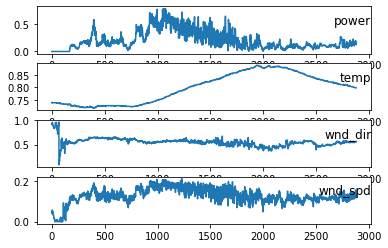

In [6]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

# 3.特徵工程
最好做下確認數據的相關性，這裏只有四個特徵就不做了

In [7]:
dataset.head()

,power,temp,wnd_dir,wnd_spd
date,,,,
2018-07-30 00:00:00,0.0,0.74,0.936787,0.040727
2018-07-30 00:00:30,0.0,0.74,0.932609,0.045691
2018-07-30 00:01:00,0.0,0.74,0.917778,0.056391
2018-07-30 00:01:30,0.0,0.74,0.929074,0.056307
2018-07-30 00:02:00,0.0,0.74,0.947130,0.056892


# 4.多變量數據轉換
- 3->1，三组预测一组--可依據訓練效果進行調整
- time_stamp：間隔數預設 3
- n_features：特徵數 = 4

In [8]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [9]:
# 标准化/放缩 特征值在（0,1）之间 避免一些噪音影響預測結果
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [10]:
scaled[0]

array([0.        , 0.12711876, 0.96344214, 0.19299276])

In [11]:
# 用3行数据预测一小时数据，4个特征值
time_stamp = 3
n_features = 4
data = scaled
n_out=1
#  查看特徵數
n_vars = 1 if type(data) is list else data.shape[1]
n_vars

4

In [12]:
df = DataFrame(data)
df.head()

,0,1,2,3
0,0.0,0.127119,0.963442,0.192993
1,0.0,0.127119,0.958759,0.216518
2,0.0,0.127119,0.942135,0.267221
3,0.0,0.127119,0.954797,0.266825
4,0.0,0.127119,0.975036,0.269596


In [13]:
cols, names = list(), list()
# input sequence (t-n, ... t-1)
# 将3组输入数据依次向下移动3，2，1行，将数据加入cols列表（技巧：(time_stamp, 0, -1)中的-1指倒序循环，步长为1）
for i in range(time_stamp, 0, -1):
    cols.append(df.shift(i))
    names += [('features%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

In [14]:
len(cols)

3

In [15]:
names

['features1(t-3)',
 'features2(t-3)',
 'features3(t-3)',
 'features4(t-3)',
 'features1(t-2)',
 'features2(t-2)',
 'features3(t-2)',
 'features4(t-2)',
 'features1(t-1)',
 'features2(t-1)',
 'features3(t-1)',
 'features4(t-1)']

In [16]:
# forecast sequence (t, t+1, ... t+n)
# 将一组输出数据加入cols列表（技巧：其中i=0）
for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('features%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('features%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

In [17]:
# cols列表(list)中现在有四块经过下移后的数据(即：df(-3),df(-2),df(-1),df)，将四块数据按列 并排合并
reframed = concat(cols, axis=1)
# 给合并后的数据添加列名
reframed.columns = names
reframed.head()

,features1(t-3),features2(t-3),features3(t-3),features4(t-3),features1(t-2),features2(t-2),features3(t-2),features4(t-2),features1(t-1),features2(t-1),features3(t-1),features4(t-1),features1(t),features2(t),features3(t),features4(t)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.127119,0.963442,0.192993
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.127119,0.963442,0.192993,0.0,0.127119,0.958759,0.216518
2,NaN,NaN,NaN,NaN,0.0,0.127119,0.963442,0.192993,0.0,0.127119,0.958759,0.216518,0.0,0.127119,0.942135,0.267221
3,0.0,0.127119,0.963442,0.192993,0.0,0.127119,0.958759,0.216518,0.0,0.127119,0.942135,0.267221,0.0,0.127119,0.954797,0.266825
4,0.0,0.127119,0.958759,0.216518,0.0,0.127119,0.942135,0.267221,0.0,0.127119,0.954797,0.266825,0.0,0.127119,0.975036,0.269596


In [18]:
# 删除NaN值列
reframed.dropna(inplace=True)
print(reframed.shape)

(2877, 16)


In [19]:
reframed.head()

,features1(t-3),features2(t-3),features3(t-3),features4(t-3),features1(t-2),features2(t-2),features3(t-2),features4(t-2),features1(t-1),features2(t-1),features3(t-1),features4(t-1),features1(t),features2(t),features3(t),features4(t)
3,0.0,0.127119,0.963442,0.192993,0.0,0.127119,0.958759,0.216518,0.0,0.127119,0.942135,0.267221,0.0,0.127119,0.954797,0.266825
4,0.0,0.127119,0.958759,0.216518,0.0,0.127119,0.942135,0.267221,0.0,0.127119,0.954797,0.266825,0.0,0.127119,0.975036,0.269596
5,0.0,0.127119,0.942135,0.267221,0.0,0.127119,0.954797,0.266825,0.0,0.127119,0.975036,0.269596,0.0,0.135594,0.989773,0.247823
6,0.0,0.127119,0.954797,0.266825,0.0,0.127119,0.975036,0.269596,0.0,0.135594,0.989773,0.247823,0.0,0.127119,0.988735,0.241093
7,0.0,0.127119,0.975036,0.269596,0.0,0.135594,0.989773,0.247823,0.0,0.127119,0.988735,0.241093,0.0,0.127119,0.968497,0.223278


# 5.數據集準備
- 訓練數據 80% 約 2200筆
- 測試集 2877-2200

In [20]:
# split into train and test sets
values = reframed.values
# 2200比數據訓練
n_train_hours = 2200
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = time_stamp * n_features
# 有16=(4*4)列数据，取前12=(3*4) 列作为X，倒数第1列=(第16列)作为Y
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)


(2200, 12) 2200 (2200,)


In [21]:
# 将数据转换为3D输入，timesteps=3，3条数据预测1条 [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], time_stamp, n_features))
test_X = test_X.reshape((test_X.shape[0], time_stamp, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(2200, 3, 4) (2200,) (677, 3, 4) (677,)


# 6.模型構造
- tf
- pytorch

## 6.2 pytorch网络

In [22]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [23]:
print(train_X.shape,train_y.shape)

(2200, 3, 4) (2200,)


In [24]:
#reshape输入为LSTM的输入格式 reshape input to be 3D [samples, timesteps, features]
# x_train = x_train.reshape((train_X.shape[0], time_stamp, train.shape[1]-1)) #将训练数据调整成pytorch中lstm算法的输入维度
train_y = train_y.reshape((train_y.shape[0], -1))
train_X = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_y)

In [25]:
train_y.shape

torch.Size([2200, 1])

In [26]:
class RNN (nn.Module):
    def __init__(self):
        super(RNN,self).__init__() 
        self.lstm = nn.LSTM(n_features,8,2) #输入数据4个特征维度，6个隐藏层维度，2个LSTM串联，第二个LSTM接收第一个的计算结果
        self.out = nn.Linear(8,1) #线性拟合，接收数据的维度为6，输出数据的维度为1
        #self.dropout = nn.Dropout(p=0.1)
    def forward(self,xx):
        x1,_ = self.lstm(xx)
        a,b,c = x1.shape
#         print(a,b,c)
        out = self.out(x1.view(-1,c))#将lstm输出的三维数据x1调整成二维数据，最后的特征维度不能变
        #out = self.dropout(out)
        out1 = out.view(a,-1) #把二维的out调整成三维数据，下一次循环使用
#         out2=out1.view(a,-1)
        return out1
rnn = RNN()

#参数寻优，计算损失函数

optimizer = torch.optim.Adam(rnn.parameters(),lr = 0.02)
loss_func = nn.MSELoss()

 
for i in range(100):
    
    var_x = Variable(train_X).type(torch.FloatTensor)
    var_y = Variable(train_y).type(torch.FloatTensor)
    out = rnn(var_x)
    loss = loss_func(out,var_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1)%10==0:
        print('Epoch:{}, Loss:{:.5f}'.format(i+1, loss.item()))

D:\anaconda\envs\ML\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([2200, 1])) that is different to the input size (torch.Size([2200, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:10, Loss:0.04410
Epoch:20, Loss:0.03559
Epoch:30, Loss:0.02745
Epoch:40, Loss:0.01188
Epoch:50, Loss:0.00934
Epoch:60, Loss:0.00737
Epoch:70, Loss:0.00699
Epoch:80, Loss:0.00669
Epoch:90, Loss:0.00658
Epoch:100, Loss:0.00649


In [27]:
import matplotlib.pyplot as plt
dataX1 = test_X#.reshape(-1,1,1)
dataX2 = torch.from_numpy(dataX1)
var_dataX = Variable(dataX2).type(torch.FloatTensor)

pred = rnn(var_dataX)

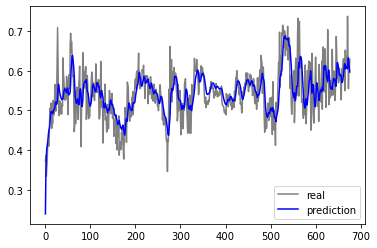

In [28]:
pred_test = pred.view(-1).data.numpy()  #转换成一维的ndarray数据，这是预测值

y_valid=test_y#.reshape(1,-1)[0]


plt.plot(y_valid, 'grey', label='real')
#預測是四個數，最後一列是我們需要的風速
plt.plot(pred[:,-1].data.numpy(), 'b', label='prediction')

plt.legend(loc='best')